<img src="https://avatars.githubusercontent.com/u/74911464?s=200&v=4"
     alt="OpenEO Platform logo"
     style="float: left; margin-right: 10px;" />
# OpenEO Platform - Surface reflectance ARD
### Interactive timeseries trajectory analysis from ARD data

### In this notebook we will perform two timeseries analysis:
1. Analysis of a NDVI (Normalized Difference Vegetation Index) timeseries with two on-demand atmospheric correction processes for Sentinel-2 (iCor and smac) and one pre-computed (Sen2Cor).
2. Analysis of a NDVI timeseries with two ARD collections (Sentinel-2 and Landsat-8).

In [121]:
from eo_utils import *
from shapely.geometry import box
from openeo.rest.conversions import timeseries_json_to_pandas
import pandas as pd

DEFAULT_FIGSIZE = (14, 7)
%matplotlib inline

# 1. NDVI timeseries analysis over a forest area with on-demand processing
## Step 1 -  Area of Interest selection
### Run the next cell, click on the rectangle button and then draw the area over the map like in the following example image
<img src="https://github.com/openEOPlatform/SRR1_notebooks/raw/main/data/images/selection_bbox_US2.jpg"
     alt="rectangle_selection"
     style="float: left; margin-right: 10px;" />

In [5]:
center = [46.34, 11.458]
zoom = 15

eoMap = openeoMap(center,zoom)
eoMap.map

Map(center=[46.34, 11.458], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_…

In [31]:
bbox = eoMap.getBbox()
print('west',bbox[0],'\neast',bbox[2],'\nsouth',bbox[1],'\nnorth',bbox[3])
bbox_poly = box(minx=bbox[0],maxx=bbox[2],miny=bbox[1],maxy=bbox[3])

west 11.441469 
east 11.466888 
south 46.334793 
north 46.344096


<img src="https://github.com/openEOPlatform/SRR1_notebooks/raw/main/data/images/Sentinel_2.jpg"
     alt="Sentinel-2"
     style="float: left; margin-right: 10px; width:100px" />
## Step 2 - openEO graph creation for Sentinel-2

1. Open the connection with openEO back-end. Use EGI login.

In [42]:
backend_url = "https://openeo-dev.vito.be"
connection = openeo.connect(backend_url).authenticate_oidc(provider_id="egi")

Authenticated using refresh token.


2. Define range of interest in time and requested bands from Sentinel-2 L1C data

In [43]:
collection      = 'SENTINEL2_L1C_SENTINELHUB'
spatial_extent  = {'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3],'crs':'EPSG:4326'}
temporal_extent = ["2020-01-01", "2020-12-31"]
bands           = ["B04","B08","CLM",'B09','B8A','B11','sunAzimuthAngles','sunZenithAngles','viewAzimuthMean','viewZenithMean']

l1c_bands = connection.load_collection(collection,bands=bands,temporal_extent=temporal_extent)

3. Apply atmospheric correction using iCor and smac

In [44]:
l2a_icor = l1c_bands.atmospheric_correction(method='iCor')

In [45]:
l2a_smac = l1c_bands.atmospheric_correction(method='smac')

In [69]:
bands_l2a = ["B04","B08","SCL"]
l2a_sen2cor = connection.load_collection('TERRASCOPE_S2_TOC_V2',spatial_extent=spatial_extent,bands=bands_l2a,temporal_extent=temporal_extent)

In [39]:
from openeo.processes import ProcessBuilder
def masked_ndvi(value:ProcessBuilder):
    nir = value.array_element(1)
    red = value.array_element(0)
    clm = value.array_element(2)
    ndvi = (nir-red)/(nir+red)
    
    return if_(neq(clm,1),ndvi)
    

In [49]:
%time ts_icor = l2a_icor.reduce_dimension(dimension="bands",reducer = masked_ndvi ).polygonal_mean_timeseries(bbox_poly).execute()

CPU times: user 5.48 ms, sys: 5.85 ms, total: 11.3 ms
Wall time: 58.1 s


In [50]:
%time ts_smac = l2a_smac.reduce_dimension(dimension="bands",reducer = masked_ndvi ).polygonal_mean_timeseries(bbox_poly).execute()

CPU times: user 11.2 ms, sys: 5.37 ms, total: 16.5 ms
Wall time: 1min 57s


Retrieve Sen2Cor ARD data, from Sentinel-2 L2A. There's two differences here:
- a predefined NDVI method is used
- a more complex cloudmasking process graph is offered by Terrascope backend in the form of 'mask_scl_dilation'. This shows how openEO allows building a library of reusable 'functions' composed of other lower level functions.

In [118]:
from openeo.processes import ProcessBuilder, eq, or_
def scl_masked_ndvi(value:ProcessBuilder):
    nir = value.array_element(1)
    red = value.array_element(0)
    clm = value.array_element(2)
    ndvi = (nir-red)/(nir+red)
    #SCL 4 == vegetation
    return if_(or_(eq(clm,6),or_(eq(clm,2),or_(eq(clm,7),or_(eq(clm,4),eq(clm,5))))),ndvi)
#.process("mask_scl_dilation", data=l2a_sen2cor,scl_band_name="SCL")
#%time ts_sen2cor = l2a_sen2cor.reduce_dimension(dimension="bands",reducer = scl_masked_ndvi).download("./data/senc2cor_ndvi_timeseries.nc", format="NetCDF")

In [ ]:
ts_sen2cor = xr.open_dataset('./data/senc2cor_ndvi_timeseries.nc',engine="h5netcdf").mean(dim=['x','y'])

In [119]:
%time ts_sen2cor = l2a_sen2cor.reduce_dimension(dimension="bands",reducer = scl_masked_ndvi).polygonal_mean_timeseries(bbox_poly).execute()

CPU times: user 6.65 ms, sys: 3.96 ms, total: 10.6 ms
Wall time: 13.8 s


## Retrieve FORCE L2A from EODC

In [135]:
eodc_conn = openeo.connect("https://openeo.eodc.eu/v1.0").authenticate_basic()

In [ ]:
west  = 10.92691 
east  = 10.92717
south = 45.846871 
north = 45.847058
bbox = [west,south,east,north]
print('Area Of Interest:','\nwest',bbox[0],'\neast',bbox[2],'\nsouth',bbox[1],'\nnorth',bbox[3])

collection      = 'boa_sentinel_2'
spatial_extent  = {'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3]}
temporal_extent = ["2016-06-01", "2017-06-01"]
bands           = ["band_4","band_8"]

s2_l2a_eodc = eodc_conn.load_collection('boa_sentinel_2',spatial_extent=spatial_extent,bands=["band_4","band_8"],temporal_extent=temporal_extent)

ndvi = s2_l2a_eodc.reduce_dimension(dimension="bands",reducer = lambda value: (array_element(value,1)-array_element(value,0))/(array_element(value,1)+array_element(value,0)))
ndvi.execute_batch("./data/force_ndvi_timeseries.nc", out_format="NetCDF")

In [132]:
job = eodc_conn.job('jb-8f5e50bb-00fb-4be1-8233-c0e0fda99f48')
job

<RESTJob job_id='jb-8f5e50bb-00fb-4be1-8233-c0e0fda99f48'>

No handles with labels found to put in legend.


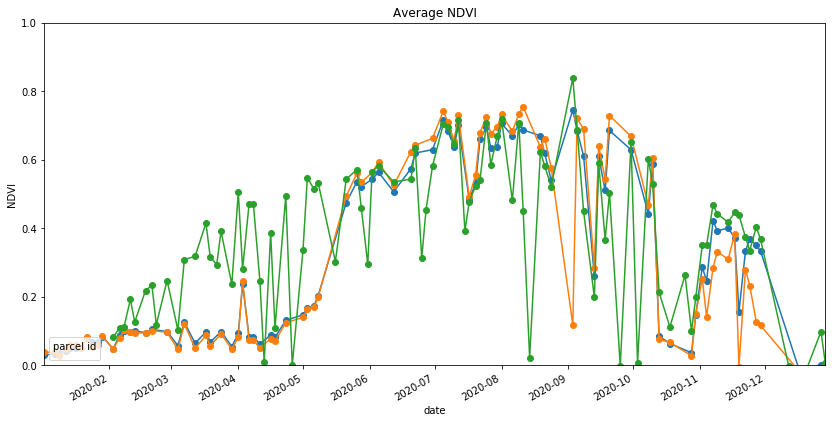

In [122]:


def plot_timeseries(ts_dict,ax):
    """Helper to plot the timeseries from a dictionary."""
    
    ts = timeseries_json_to_pandas(ts_dict).dropna()
    ts.index = pd.to_datetime(ts.index)
    ts.plot(marker='o', ax=ax)
    
fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)

ax.set_title("Average NDVI"); ax.set_ylabel("NDVI");ax.set_ylim(0, 1)
ax.legend(title="parcel id", loc="lower left", ncol=2)

plot_timeseries(ts_icor,ax)
plot_timeseries(ts_smac,ax)
plot_timeseries(ts_sen2cor,ax)
#ts_sen2cor.dropna(dim='t').hvplot()